# **Computer Vision - Assignment 3 - IMAGE REGISTRATION USING HOMOGRAPHIES**
#### Value: 10 (+4) points | Due date: December 22 23:59 | Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: Pedro Ramos Suárez


In this assignment you will learn:

a) How to detect relevant regions using the Harris's algorithm.

b) How to detect matches between images using SIFT descriptors.

c) How to compose a mosaic from a bunch of images. 

## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Para poder evaluar el BONUS se debe obtener al menos el 70% de los puntos de la parte obligatoria

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb, y ficheros auxiliares externos: P0.py y P1.py) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse junto con los resultados obtenidos en cada apartado y los  correspondientes comentarios, explicaciones y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

The next cell is intended to install an upgrade of the OpenCV package that includes the SIFT algorithm. After the installation, the  python-kernel (restart runtime) has to be restarted to import the new release.

In [ ]:
import sys, cv2
(major, minor,_)=cv2.__version__.split(".")
if int(minor) < 5:
  if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())

print(cv2.__version__)

4.6.0


This cell sets the environment and imports your packages

In [ ]:
# Let's start importing all background modules
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys, os
# change directory
%cd '/content/drive/MyDrive'
# Let's import the python module exercises.py  to have access to its functions and Classes
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))
import P0, P1
get_image = lambda route: os.path.join('/content/drive/My Drive/images/', route)
import numpy as np
from matplotlib import pyplot as plt

Mounted at /content/drive
/content/drive/MyDrive


Volvemos a definir una función de la práctica 0. Funciona exactamente igual que en dicha práctica, excepto que utiliza un nuevo parámetro, factor, que permite aumentar el tamaño de la imagen de salida.

In [ ]:
import math

def print_images_titles(vim, title=None, titles=None, rows=0, factor=1):
  fig = plt.figure()

  if rows > 0:
    columns = math.ceil(len(vim)/rows)
  else:
    rows, columns = P0.imDistribution(len(vim))

  # Add images
  i=1
  for image in vim:
    ax = fig.add_subplot(rows, columns, i)
    if titles is not None:
      ax.title.set_text(titles[i-1])
    if len(image.shape) == 3:
      ax.imshow(image)
    else:
      ax.imshow(image, cmap='gray')
    ax.axis('off') # Remove axis
    i+=1

    if title is not None:
      fig.suptitle(title)
    
  fig.tight_layout()
  plt.gcf().set_size_inches(factor * plt.gcf().get_size_inches())

También volvemos a definir la función para visualizar imágenes para eliminar la normalización.

In [ ]:
def displayIm(im, title='Result', factor=1, showFlag=np.True_):
  fig, ax = plt.subplots()
  # Display the image
  if len(im.shape) == 3:
    # im has three channels (RGB)
    ax.imshow(im)
  else:
    # im has a single channel (Grayscale)
    ax.imshow(im, cmap='gray')
    
  figure_size = plt.gcf().get_size_inches()
  plt.title(title) # Adding title
  plt.gcf().set_size_inches(factor * figure_size)
  plt.xticks([]), plt.yticks([]) # Axis label off
  if showFlag: plt.show()

# **Exercise 1:** Harris detector and non-maxima suppresion (3 points)

Write Python code to implement the detection of the strongest 100-150 Harris points in an image, and show your results using the function cv2.drawKeyPoints(). You can apply OpenCV's functions getDerivKernels() and sepFilter2D(). However, those who use their own code from P1 (for computing the derivatives) could have a bonus of +1 point. 

Hint (use different cells for the items):\
a) Fix the derivative and integration scales. Try first sigma values in the range 1-3.\
b) Compute the derivative images. \
c) Compute the three terms of the second moment matrix (SMM) at each pixel. To do it, apply the convolution with a Gaussian mask of size the integration area. \
d) Compute the Harris value at each pixel (discard the points close to the edges).\
e) Apply Non-Maxima Suppression by using the function corner_peaks() from the module skimage.features. The student must set the minimum distace between maxima. The output will be a list of (x,y) coordinates.  Extract the values in these coordinates and create a list of vectors (x,y,value).\
f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma (sigma=3) and computing the orientation of the gradient at those points.\
d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including (x,y,scale,orientation).\
e) Draw the keypoints on the image using the function cv2.drawKeypoints().


Comenzamos realizando el código para el cálculo de la matriz de Harris. Para ello, usaremos el cálculo de las derivadas de la práctica 1 (my2DConv(im, sigma, [ordenX, ordenY]) aplica a la imagen im la máscara de orden indicada por los órdenes [ordenX, ordenY], que representan respectivamente el grado de la derivada respecto al eje X y al eje Y, entendiendo orden [0,0] como la máscara gaussiana).

Para el cálculo de la matriz Harris, usamos la matriz H:
$$H(u, v) = \begin{pmatrix}
\sum_{w} w(x, y) \delta I_{x}^{2} & \sum_{w} w(x, y) \delta I_{x} \delta I_{y} \\
\sum_{w} w(x, y) \delta I_{x} \delta I_{y} & \sum_{w} w(x, y) \delta I_{y}^{2}
\end{pmatrix}$$
Y a partir de esta matriz, podemos calcular la matriz de Harris:
$$f_{h} = \frac{\lambda_{1}\lambda_{2}}{\lambda_{1} + \lambda_{2}} = \frac{\operatorname{det}(H)}{\operatorname{det}(H)} = \frac{(\sum_{w} w(x, y) \delta I_{x}^{2} \cdot \sum_{w} w(x, y) \delta I_{y}^{2}) - (\sum_{w} w(x, y) \delta I_{x} \delta I_{y} \cdot \sum_{w} w(x, y) \delta I_{x} \delta I_{y})}{\sum_{w} w(x, y) \delta I_{x}^{2} + \sum_{w} w(x, y) \delta I_{y}^{2}}$$

In [ ]:
# Compute image derivatives
def derivatives(im, sigmaD):
  dx = P1.my2DConv(im, sigmaD, [1,0])
  dy = P1.my2DConv(im, sigmaD, [0,1])
  return dx, dy

# Compute Harris-criterium Map
def HarrisMap(dx, dy, sigmaI):
  # Compute the three terms of the SMM at each pixel and he map values
  dxx = P1.my2DConv(np.multiply(dx, dx), sigmaI, [0,0])
  dxy = P1.my2DConv(np.multiply(dx, dy), sigmaI, [0,0])
  dyy = P1.my2DConv(np.multiply(dy, dy), sigmaI, [0,0])

  HMap = None
  # 3D image (color)
  if len(dx.shape) == 3:
    HMap = np.empty(([len(dx), len(dx[0]), 3]))
    for i in range(len(dx)):
      for j in range(len(dx[0])):
        for k in range(3):
          if (dxx[i,j,k] + dyy[i,j,k]) != 0:
            HMap[i,j,k] = ((dxx[i,j,k] * dyy[i,j,k]) - (dxy[i,j,k] * dxy[i,j,k])) / (dxx[i,j,k] + dyy[i,j,k])
          else:
            HMap[i,j,k] = 0
  # 2D image (gray scale)
  elif len(dx.shape) == 2:
    HMap = np.empty(([len(dx), len(dx[0])]))
    for i in range(len(dx)):
      for j in range(len(dx[0])):
        if (dxx[i,j] + dyy[i,j]) != 0:
          HMap[i,j] = ((dxx[i,j] * dyy[i,j]) - (dxy[i,j] * dxy[i,j])) / (dxx[i,j] + dyy[i,j])
        else:
          HMap[i,j] = 0

  return HMap

Visualicemos el Harris Map con una imagen que usaremos más adelante:

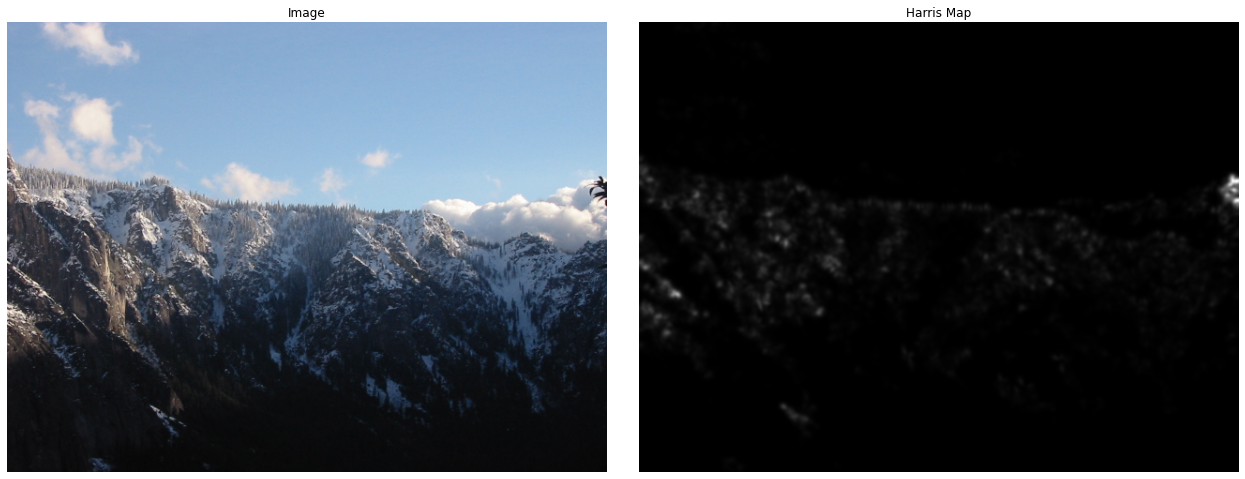

In [ ]:
img = P0.readIm(get_image('yosemite7.jpg'), 1)
im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
dx, dy = derivatives(im, 1.5)
print_images_titles([img, P0.rangeDisplay01(HarrisMap(dx=dx, dy=dy, sigmaI=1.5*1.5), 1)], titles=["Image", "Harris Map"], factor=3)

Podemos ver que las zonas mas iluminadas son donde hay un mayor contraste, como por ejemplo, en la parte derecha de la imagen entre las hojas (negras) y las nubes (blancas).

Podemos visualizarlo con otra imagen:

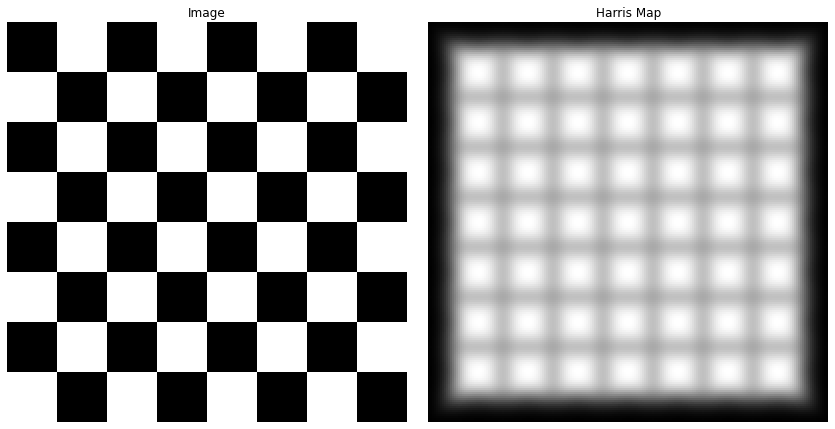

In [ ]:
from skimage.feature import corner_peaks

chess_img = np.zeros((200,200,3), dtype=np.uint8)
for i in range(200):
  for j in range(200):
    if (i % 50 < 25 and not j % 50 < 25) or (not i % 50 < 25 and j % 50 < 25):
      chess_img[i,j] = [255,255,255]

chess_im = cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY)
dx, dy = derivatives(chess_im, 3)
print_images_titles([chess_img, P0.rangeDisplay01(HarrisMap(dx=dx, dy=dy, sigmaI=5*1.5), 1)], titles=["Image", "Harris Map"], factor=2)

En este caso podemos ver cuadrados centrados en las esquinas del cada casilla del tablero de ajedrez, que es donde se encuentran los bordes.

The following cell implements the Non-Maxima-Suppression stage. This function calls the corner_peaks() function from the skimage.feature package (see below). This function returns the local maxima sorted by value.

A partir de la matriz de Harris, podemos calcular los puntos de borde. Como los valores de la matriz de Harris dependen de la imagen, para poder 'normalizarlos' y que así podemos usar los mismos valores de threshold sin importar la imagen, realizamos:
$$harrisMap(x, y) = \frac{harrisMap(x, y)}{\sup\{harrysMap(x, y)\}}$$
es decir, todos los valores estarán en [0,1].

In [ ]:
from skimage.feature import corner_peaks

def NonMaximaSuppression(harrisMap, min_distance, threshold):
  harrisMap = harrisMap/harrisMap.max()
  points = corner_peaks(harrisMap, min_distance=min_distance)

  response = []
  for i in range(len(points)):
    response.append(harrisMap[points[i,0], points[i,1]])

  n = (np.asarray(response) > threshold).sum()
  # check the order
  values = response[:n]
  coord = points[:n, [0,1]]
  return coord, values

Vamosa visualizar los puntos obtenidos con la función anterior:

In [ ]:
sigmas = [1, 1.5, 2, 2.5, 3]
images = []
for sigma in sigmas:
  dx, dy = derivatives(im, sigma)
  coords, values = NonMaximaSuppression(HarrisMap(dx=dx, dy=dy, sigmaI=1.5*sigma), min_distance=3, threshold=0.1)

  fig, ax = plt.subplots()
  ax.imshow(img, cmap=plt.cm.gray)
  ax.plot(coords[:, 1], coords[:, 0], c='cyan', marker='o', linestyle='None', markersize=6)
  plt.gcf().set_size_inches(2 * plt.gcf().get_size_inches())
  plt.title("Harris points on yosemite7.jpg, sigma="+str(sigma))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Podemos ver como, al cambiar el valor de sigma, los puntos obtenidos cambian. De nuevo, podemos ver como los puntos están donde se esperaban, en las zonas de mayor contraste.

Esto se debe a que, si tomamos un sigma mayor, el tamaño de la máscara es mayor, y el algoritmo Harris es dependiente de esto, provocando que detecte bordes o no dependiendo del valor usado.

Visualiicemos también los puntos en la imagen del tablero de ajedrez:

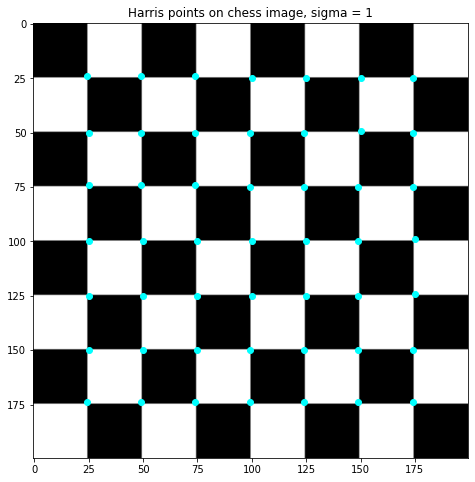

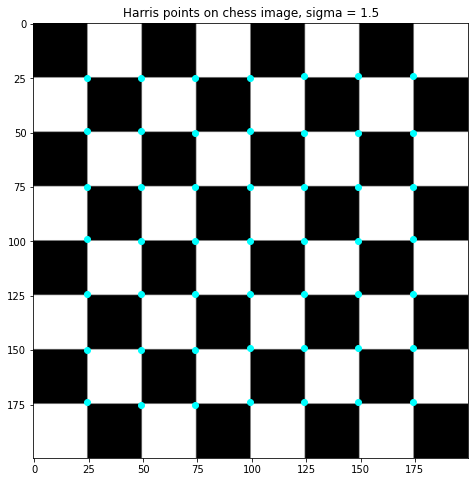

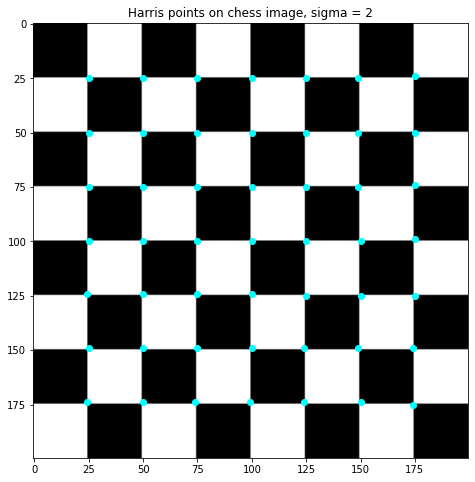

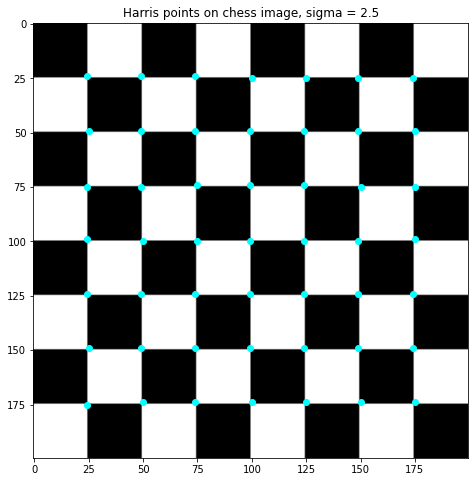

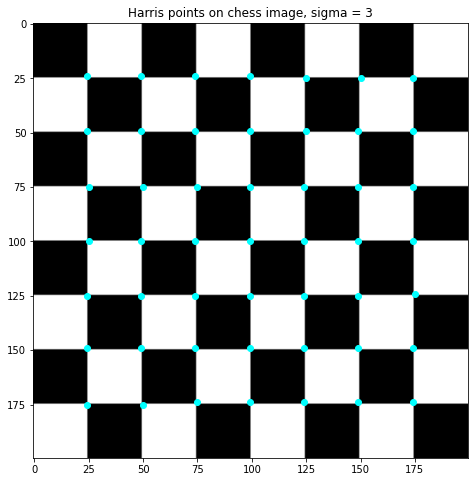

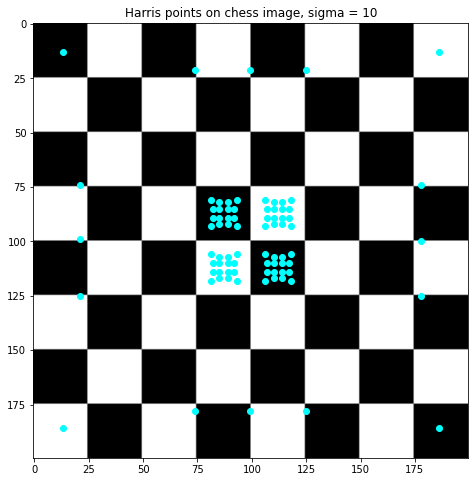

In [ ]:
sigmas = [1, 1.5, 2, 2.5, 3, 10]
for sigma in sigmas:
  dx, dy = derivatives(chess_im, sigma)
  coords, values = NonMaximaSuppression(HarrisMap(dx=dx, dy=dy, sigmaI=sigma*1.5), min_distance=1, threshold=0.1)

  fig, ax = plt.subplots()
  ax.imshow(chess_img, cmap=plt.cm.gray)
  ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
  plt.gcf().set_size_inches(2 * plt.gcf().get_size_inches())
  plt.title('Harris points on chess image, sigma = '+str(sigma))
  plt.show()

De nuevo, como esperábamos, los puntos se encuentran en las esquinas de las casillas. En este caso, para los tamaño de la máscara pequeños obtenemos los mismos puntos, ya que las máscaras que detentan estos bordes usan pixeles de las casillas adyacentes, tanto blancos como negros. Si tomamos un valor mucho mas grande de sigma, como podemos ver en el último caso, la máscara tiene un tamaño mucho mayor y toma valores de muchas casillas, por lo que no detecta las esquinas como bordes.

Recordemos que el tamaño de la máscara es:
$$maskSize = 3 * \operatorname{ceil}(\sigma)+1$$

Por lo que en, para los primeros sigmas, tenemos:
$$\sigma = \{1, 1.5, 2, 2.5, 3\} \Rightarrow maskSize = \{4, 7, 7, 10, 10\}$$
Y como cada casilla es de 25 pixeles, cuando la máscara detecte las esquinas tiene pixeles de dos cuadrados blancos y dos negros.

Sin embargo, en el último caso tenemos:
$$\sigma = 10 \Rightarrow maskSize = 31$$
Por lo que en este caso usará píxeles de más casillas además de las cuatro alrededor de la esquina, lo cuál provoca que no la detecte.

Orientation is computed as the angle of the gradient after smoothing the derivative images with a Gaussian (with sigma=3).

A KeyPoint is an OpenCV's structure, associated to each detected region,  necessary to call OpenCV feature extraction algorithms. You have to create one KeyPoint structure per detected region with information about (location, scale,orientation). (See the OpenCV documentation for more information)

Para calcular la orientación, usamos la fórmula:
$$\theta = \frac{\arctan(\frac{\operatorname{smooth}(dy)}{\operatorname{smooth}(dx)}) \cdot 180}{\pi}$$
Multiplicar por $\frac{180}{\pi}$ es para pasar de radianes a grados, y $\operatorname{smooth}(dx)$ es la matriz obtenida de aplicar una máscara gaussiana a la derivada.

Con esto, podemos crear los key points, para los que utilizaremos como tamaño el valor del punto en la matriz de Harris, por lo que los puntos de mayor contraste serán de mayor tamaño. Además, multiplicamos este valor por una constante que dependerá del tamaño de la imagen, para que sin importar qué tan grande sea la imagen, tengan tamaños similares.

In [ ]:
# compute the orientation map
def orientation(dx, dy):
  # Let's compute  orientation in degrees
  smoothdx = P1.my2DConv(dx, 1.5, [0,0])
  smoothdy = P1.my2DConv(dy, 1.5, [0,0])
  theta = np.zeros([dx.shape[0], dx.shape[1]])
  for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
      theta[i,j] = math.atan2(smoothdy[i,j], smoothdx[i,j])
      theta[i,j] = theta[i,j]*180/math.pi
  return theta

# Create the KeyPoint list from the information about locations, orientations and scale 
# keyPoint = KeyPoint(x_float, y_float, scale_float, orientation_float), in Harris scale=1
def keyPoints(coord, theta, size):
  keyPoint = []
  scale = theta.shape[0]*theta.shape[1] / (3*10**3)
  for i in range(len(coord)):
    keyPoint.append(cv2.KeyPoint(float(coord[i,1]), float(coord[i,0]), size=size[i]*scale, angle=theta[coord[i,0], coord[i,1]]))
  return keyPoint

The following cell computes the Harris KeyPoints detection (calling to the previously implemented functions, like derivatives(), HarrisMap(), NonMaximaSuppression(), orientation() and keyPoints()), and displays them on the image. Use the function cv2.drawKeypoints() with flags, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS.

Con todo esto, ya podemos calcular los key points y visualizarlos sobre la imagen:

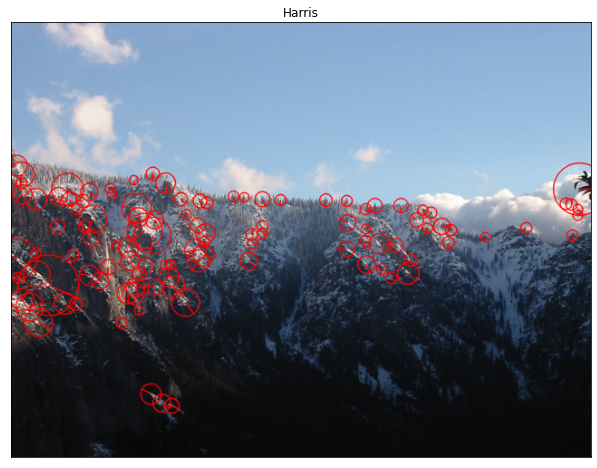

In [ ]:
# Let's compute the KeyPoints-Harris and display them
from skimage.feature import corner_peaks
img = P0.readIm(get_image('yosemite7.jpg'), 1)
im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# parameters
sigmaD = 1.5
sigmaI = sigmaD * 1.5
min_distance = 5
Threshold_MINVALUE = 0.1
#
dx, dy = derivatives(im, sigmaD)
coords, values = NonMaximaSuppression(HarrisMap(dx=dx, dy=dy, sigmaI=sigmaI), min_distance=min_distance, threshold=Threshold_MINVALUE)
theta = orientation(dx, dy)
#
kp = keyPoints(coords, theta, values)
cv2.drawKeypoints(img, kp, img, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
displayIm(img, factor=2, title='Harris')
smoothed = img

Podemos ver que los puntos son los que habíamos obtenido previamente, pero ahora también podemos ver su tamaño y su ángulo.

Visualicemos también los puntos en el tablero del ajedrez:

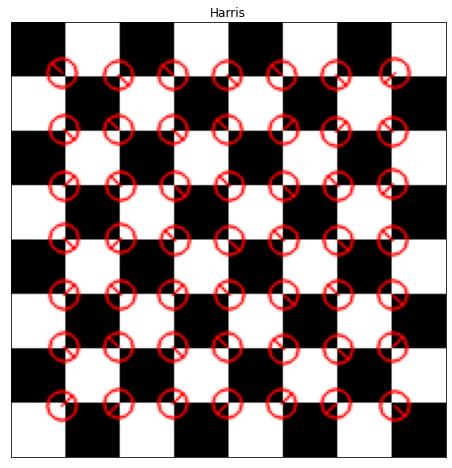

In [ ]:
chess_img = np.zeros((200,200,3), dtype=np.uint8)
for i in range(200):
  for j in range(200):
    if (i % 50 < 25 and not j % 50 < 25) or (not i % 50 < 25 and j % 50 < 25):
      chess_img[i,j] = [255,255,255]

chess_im = cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY)

# parameters
sigmaD = 5
sigmaI = sigmaD * 1.5
min_distance = 5
Threshold_MINVALUE = 0.1
#
dx, dy = derivatives(chess_im, sigmaD)
coords, values = NonMaximaSuppression(HarrisMap(dx=dx, dy=dy, sigmaI=sigmaI), min_distance=min_distance, threshold=Threshold_MINVALUE)
theta = orientation(dx, dy)
#
kp = keyPoints(coords, theta, values)
cv2.drawKeypoints(chess_img, kp, chess_img, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
displayIm(chess_img, factor=2, title='Harris')

De nuevo, obtenemos los puntos en las esquinas de las casillas, y todos son del mismo tamaño, como se esperaba.

Finalmente, vamos a ver por qué utilizábamos $\operatorname{smooth}(dx)$ en lugar de la derivada directamente.

Para ello, visualicemos los puntos obtenidos de ambas formas, y veremos como son distintos:

In [ ]:
# compute the orientation map
def nonSmoothedOrientation(dx, dy):
  # Let's compute  orientation in degrees
  theta = np.zeros([dx.shape[0], dx.shape[1]])
  for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
      theta[i,j] = math.atan2(dy[i,j], dx[i,j])
      theta[i,j] = theta[i,j]*180/math.pi
  return theta

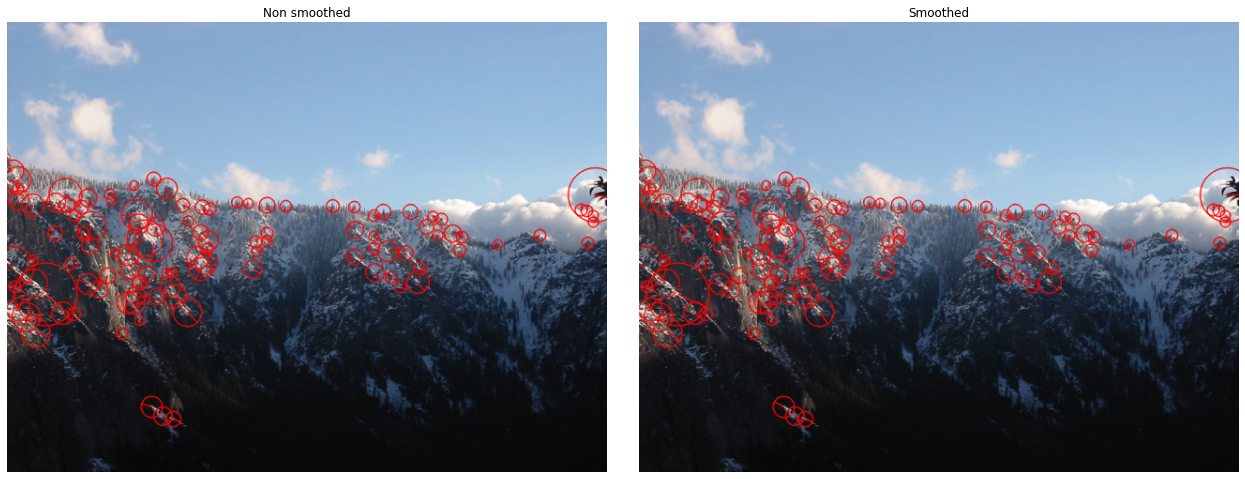

In [ ]:
img = P0.readIm(get_image('yosemite7.jpg'), 1)
im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# parameters
sigmaD = 1.5
sigmaI = 1.5 * 1.5
sizeIMask = None
min_distance = 5
Threshold_MINVALUE = 0.1
#
dx, dy = derivatives(im, sigmaD)
coords, values = NonMaximaSuppression(HarrisMap(dx=dx, dy=dy, sigmaI=sigmaI), min_distance=min_distance, threshold=Threshold_MINVALUE)
theta = nonSmoothedOrientation(dx, dy)
#
kp = keyPoints(coords, theta, values)
cv2.drawKeypoints(img, kp, img, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_images_titles([img, smoothed], titles=["Non smoothed", "Smoothed"], factor=3)

Nótese que los puntos obtenidos son muy parecidos en ángulos, con algunas diferencias en los ángulos, como se puede ver en el punto de mayor tamaño de la parte inferior de la imagen.

# **Exercise 2:** Matching keypoints between images using SIFT descriptors (2 points)

Write Python code to compute the matching between points from two images. To do so apply the SIFT algorithm to extract points and descriptors in both images.  Use the Force-Brute cross-check criteria and the KNN one to compute matches, and draw the matches between images using the function cv2.drawMatches(). 

Comenzamos calculando los puntos de SIFT:

In [ ]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(im, nfeatures=5000):
  sift = cv2.SIFT_create(nfeatures)
  kp, ds = sift.detectAndCompute(im, None)
  return kp, ds

In OpenCV the output of a matching process is a vector of matches. Each match provides information about the indexes of the matched KeyPoints and the distance between them.

Y creamos una función para poder visualizarlos sobre la imagen:

In [ ]:
# This function display the KeyPoints of an image
def showKP(im, kp, title):
  img = im.copy()
  cv2.drawKeypoints(im, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  P0.displayIm(img, title, factor=2)

Podemos visualizarlos sobre una imagen de las que utilizaremos más adelante:

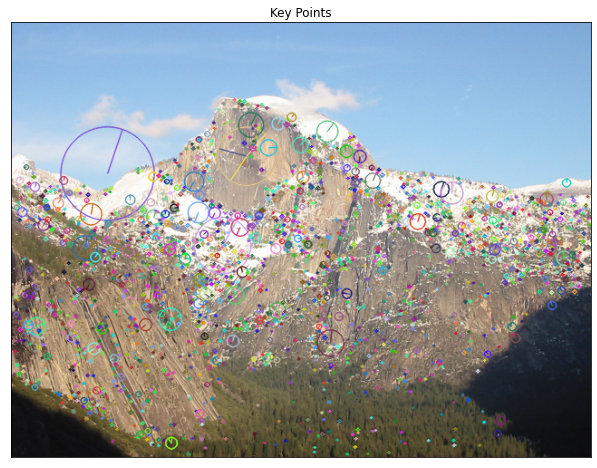

In [ ]:
img1 = P0.readIm(get_image('yosemite2.jpg'), 1)
kp, ds = siftPoints(img1)
showKP(img1, kp, 'Key Points')

O también podemos visualizarlos sobre imagen del tablero del ajedrez:

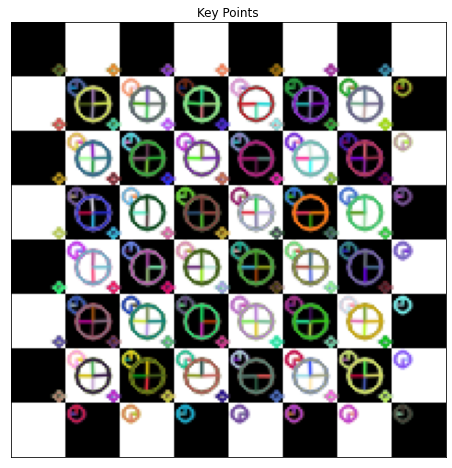

In [ ]:
chess_img = np.zeros((200,200,3), dtype=np.uint8)
for i in range(200):
  for j in range(200):
    if (i % 50 < 25 and not j % 50 < 25) or (not i % 50 < 25 and j % 50 < 25):
      chess_img[i,j] = [255,255,255]

kp, ds = siftPoints(chess_img)
showKP(chess_img, kp, 'Key Points')

Finalmente, definimos dos funciones, para poder visualizarlos puntos SIFT en común entre dos imagenes para así, como haremos en el ejercicio siguiente, poder 'pegarlas':

In [ ]:
# This function display the matches between two images
def showMatches(im1, kp1, im2, kp2, matches, N, title='Matches'):
  img = cv2.drawMatches(im1, kp1, im2, kp2, matches[:N], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  P0.displayIm(img, title=title, factor=4)

#This function compute matches between descriptors of two images
def matching(ds1, ds2, FlagMode='BF'):
  if FlagMode == 'BF':
    bf = cv2.BFMatcher(crossCheck=True)
    # Match descriptors.
    matches = bf.match(ds1, ds2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    return matches
  elif FlagMode == 'KNN':
    bf = cv2.BFMatcher(crossCheck=False)
    # Match descriptors.
    matches = bf.knnMatch(ds1, ds2, k=2)
    # Apply ratio test
    output = []
    for m, n in matches:
      if m.distance < 0.75*n.distance:
          output.append(m)
    output = sorted(output, key = lambda x:x.distance)
    return output
  else:
    return print('Error in Matching mode')

En ambos casos ordenamos los matches para obtener primero los mejores.

Now check your functions about KeyPoints and matching. To do so, read two consecutive images, let say Yosemite1 and Yosemite2, and show and analyze the results obtained.

Visualicemos los resultados obtenidos con dos imágenes distintas de un mismo paisaje:

In [ ]:
# Here we check our functions 
img1 = P0.readIm(get_image('yosemite1.jpg'),1)
im1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

img2 = P0.readIm(get_image('yosemite2.jpg'),1)
im2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

# let's compute points and descriptors
kp1, ds1 = siftPoints(img1)
kp2, ds2 = siftPoints(img2)
showKP(img1, kp1, 'KeyPoints1')
showKP(img2, kp2, 'KeyPoints2')

matches = matching(ds1, ds2)
showMatches(img1, kp1, img2, kp2, matches, 100, title='100 Matches BF')
matches = matching(ds1, ds2, FlagMode='KNN')
showMatches(img1, kp1, img2, kp2, matches, 100, title='100 Matches KNN')

Output hidden; open in https://colab.research.google.com to view.

En ambos casos, podemos ver como los 100 puntos coinciden perfectamente (es fácil de ver ya que todas las líneas que unen los puntos en ambas imágenes son paralelas entre si).

# **Exercise 3.A:** Homographies calculation (1 point)

Now you are ready to calculate the homographies. To calculate the homography between two images call the function cv2.findHomography(), which takes as input the lists of located KeyPoints (in both images) and the matches found between them. Use RANSAC to perform a robust estimation.

Comenzamos calculando las matrices de homografías, que se usaran para mover una imagen y que coincida con la adyacente. Estas matrices las optenemos a partir de los puntos de SIFT: 

In [ ]:
# this function computes a homography
def homography(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20):
  # the order is important
  if len(matches) > MIN_MATCH_COUNT:
    # Let's extract  two lists of points in correspondences from matches
    src_pts = []
    dst_pts = []
    for m in matches:
      src_pts.append(kp1[m.queryIdx].pt) 
      dst_pts.append(kp2[m.trainIdx].pt)
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    # before changing parameter values, try first the opencv by default.
    H, mask = cv2.findHomography(src_pts, dst_pts, Ransac_Error)
    # print('Inliers:', sum(mask))
  else:
     print('Error - very few matches')
  return H

# **Exercise 3.B:** Building a mosaic (4 points)


To compose a mosaic we will need to set several pieces of information. \
a) The size of the canvas according to the number of images to be stitched and their dimensions.\
b) The central image that will give the axes to the mosaic.\
c) The order of each image with respect to the central one.\
d) The homography to copy the central image into the canvas.

Here is the guideline to compute a lineal Mosaic:\
a) Read the images in the order left-right of the camera.\
b) Set one central image as the reference to give axes to the canvas.\
c) Compute the homography between each two consecutive images in your list.\
d) Set the canvas and the reference homography.\
e) Compute the homography between each image and the canvas.\
f) Use  the function cv2.warpPerspective() to transport the images to the canvas using the computed homographies.\
g) Remove redundant black-pixels.



Definimos varias funciones:


*   computeLocalHomographies: Cálcula las homografías entre imágenes adyacentes utilizando la función anterior.
*   mosaicHomographies: Cálcula la homografía de cada imagen al canvas.
*   axesHomography: Cálcula la homografía al centro del canvas.

La homografía resultante para cada imagen sera la composición de todas las imágenes adyacentes hasta llegar a la imagen que consideramos como central, más la composición con la homografía que lleva la imagen central al centro del canvas.

In [ ]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images):
  H = []
  Ransac_Error = cv2.RANSAC
  for item in range(0, len(images)-1):
    kp1, ds1 = siftPoints(images[item])
    kp2, ds2 = siftPoints(images[item+1])
    matches = matching(ds1, ds2)
    Haux = homography(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20)
    H.append(Haux)
    # print(Haux)
  return H

# this function computes the homography from each image to the canvas
def mosaicHomographies(H, idx):
  # idx is the index of the reference image
  # invert homographies
  for item in range(idx, len(H)):
    H[item] = np.linalg.inv(H[item])

  # compute homographies by compositoon
  for item in range(idx-2, -1, -1):
    H[item] = np.dot(H[item+1], H[item])
  for item in range(idx+1, len(images)-1, 1):
    H[item] = np.dot(H[item-1], H[item])
  return H

# this function fixes the homography from the central image to the canvas
# others definitions are possible
def axesHomography(nim, sizeim, sizecanvas):
  H = np.eye(3)
  H[0,2] = sizecanvas[1]//2 - sizeim[1]//2
  H[1,2] = sizecanvas[0]//2 - sizeim[0]//2
  return H

Finalmente, definimos las siguientes funciones:


*   setCanvas: Crea un canvas en negro. Este canvas tendrá de tamaño dos veces la altura de las imágenes (que todas son del mismo tamaño), y n veces el ancho de las imágenes, siendo n el número de imágenes. De esta forma, si las imágenes son obtenidas de una panorámica (de izquierda a derecha), entrarán en este canvas.
*   blackOut: Elimina los bordes en negro del canvas después de pegar las imágenes.
*   composeMosaic: Crea la imagen resultante a partir de las matrices de homografías y el canvas en negro.

Esta última función crea el mosaico creando el canvas en negro, calculando las homografías para cada imagen (comenzando por las imágenes de un extremo hasta la central, y luego del otro extremo hasta la central), componiendo cada una con la homografía que llema la imagen central al centro del canvas, y realizando las transformaciones necesarias a cada imagen con la función warpPerspective.

In [ ]:
# Auxiliary functions
# this function defines and return the canvas
def setCanvas(row, col, flagColor, nim=2):
  rows = 4 * row
  cols = 2 * nim * col
  if flagColor == 3:
    return np.zeros([rows, cols, 3], dtype=np.uint8)
  else:
    return np.zeros([rows, cols], dtype=np.uint8)

# This function removes the redundant black-pixels from the canvas
def blackOut(img):
  if len(img.shape) == 3:
    im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8) 
    x, y, w, h = cv2.boundingRect(mask)
    return img[y:y+h,x:x+w,:]
  else:
    mask = np.array((img > 0), np.uint8) 
    x, y, w, h = cv2.boundingRect(mask)
    return img[y:y+h,x:x+w]
  
# this function composes the mosaic from the extremes to the center
# transporting each image with its homography
def composeMosaic(images, canvas, H, idxc, H0, flagAffinity):
  height = canvas.shape[0]
  width = canvas.shape[1]

  nH = 0
  # global composition
  for nim in range(0, idxc):
    if nim == idxc:
      print('nim =', nim, 'nH =', 0)
      Haux = H0
    else:
      print('nim =', nim, 'nH =', nH)
      Haux = np.dot(H0, H[nH])
      nH = nH+1
    # print(Haux/Haux[2,2])
    canvas = cv2.warpPerspective(images[nim], Haux, (width, height), dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    displayIm(blackOut(canvas), factor=2, title=str(nim))

  nH = len(H)-1
  for nim in range(len(images)-1, idxc-1, -1):
    if nim == idxc:
      print('nim =', nim, 'nH =', 0)
      Haux = H0
    else:
      print('nim =', nim, 'nH =', nH)
      Haux = np.dot(H0, H[nH])
      nH = nH-1
    # print(Haux/Haux[2,2])
    canvas = cv2.warpPerspective(images[nim], Haux, (width, height), dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    displayIm(blackOut(canvas), factor=2, title=str(nim))
  return canvas


The next cell contains the mosaic catalog with 5 possible scenarios: 

- EXAMPLE 1 (rectangular projection with 4 Yosemite images) (2 points)

- EXAMPLE 2 (rectangular projection with 8 corridor images) (3 points)

- EXAMPLE 3 (rectangular projection with 10 office images) (4 points)

- EXAMPLE 4 (14 images of Granada/Alhambra, mainly for spherical projection; see Bonus)

- EXAMPLE 5 (14 images of Sierra Nevada, mainly for spherical projection; see Bonus)

In [ ]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion
def imageList(mosaicIndex):
  images = []
  
  #EXAMPLE:1 (easy, for rectangular projection) (2 points)
  if mosaicIndex == 1: 
    PREFIX=''
    nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
    for item in nameImages:
      #images.append(P0.readIm(cv2.cvtColor(get_image(PREFIX+item), flagColor=1)), cv2.COLOR_BGR2RGB)
      images.append(P0.readIm(get_image(PREFIX+item)))
    
  # EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
  elif mosaicIndex == 2:
    PREFIX='corridor/'
    nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
    for item in nameImages:
      #images.append(P0.readIm(cv2.cvtColor(get_image(PREFIX+item), flagColor=1)), cv2.COLOR_BGR2RGB)
      images.append(P0.readIm(get_image(PREFIX+item)))

  # EXAMPLE-3 (rectangular projection) (4 points)
  elif mosaicIndex == 3:
    PREFIX='despacho/'
    nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
            'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
    for item in nameImages:
      #images.append(P0.readIm(cv2.cvtColor(get_image(PREFIX+item), flagColor=1)), cv2.COLOR_BGR2RGB)
      images.append(P0.readIm(get_image(PREFIX+item)))

  # EXAMPLE-4 (mainly for spherical projection)
  elif mosaicIndex == 4:
    PREFIX = 'Granada/IMG_20211030_1104'
    nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
              '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
              '34_S.jpg','36_S.jpg']
    for item in nameImages:
      #images.append(P0.readIm(cv2.cvtColor(get_image(PREFIX+item), flagColor=1)), cv2.COLOR_BGR2RGB)
      images.append(P0.readIm(get_image(PREFIX+item)))


  # EXAMPLE-5 (mainly for spherical projection)
  elif mosaicIndex==5:
    PREFIX='SierraNevada/IMG_20220312_1029'
    nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
              '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
              '57_S.jpg','58_S.jpg'] 
    for item in nameImages:
      #images.append(P0.readIm(cv2.cvtColor(get_image(PREFIX+item), flagColor=1)), cv2.COLOR_BGR2RGB)
      images.append(P0.readIm(get_image(PREFIX+item)))
  else:
      print('Error - no such Mosaic')

  return images

Rectangular projection: The target is example-3. Example 1 and 2 are also possible but you get a lower mark (see the mosaic catalog). You must use all images.

Añadimos todos los pasos necesarios en una función, para así poder visualizarlo facilmente con cada conjunto de imágenes:

In [ ]:
from numpy.linalg import inv

def mosaico(images, idxc, factor=3):
  # Compute local homographies beetwen images
  H = computeLocalHomographies(images)
  # Set the canvas
  canvas = setCanvas(row=images[idxc].shape[0], col=images[idxc].shape[1], flagColor=3, nim=len(images))
  # Compute the homography given axis to the canvas
  H0 = axesHomography(len(images), images[idxc].shape, canvas.shape)
  # Compute the homographies between images and the canvas
  H = mosaicHomographies(H, idxc)
  # Compose the mosaic transporting the images into the canvas
  mosaic = composeMosaic(images, canvas, H, idxc, H0, 0)
  displayIm(blackOut(mosaic), factor=factor, title='Mosaico')

### Resultado imágenes pasillo

Vamos a ver un resultado por separado, que es usando las imágenes del pasillo, ya que como veremos a continuación es interesante estudiarlo en detalle.

In [ ]:
images = imageList(2)
mosaico(images, 4)

Output hidden; open in https://colab.research.google.com to view.

Podemos ver como la parte de la izquierda de la imagen es correcta, pero en la parte de la derecha, especialmente si nos fijamos en la lámpara, hay un pequeño fallo.

Vamos a intentar ver a que se debe el fallo, y para ello vamos a obtener las imágenes involucradas, y aplicarles las transformaciones que les realizamos al unirlas, y a ver los puntos SIFT en común entre estas dos imágenes en las que se encuentra el fallo:

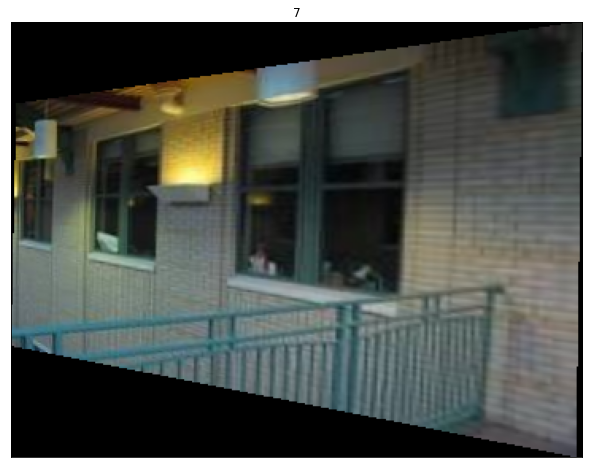

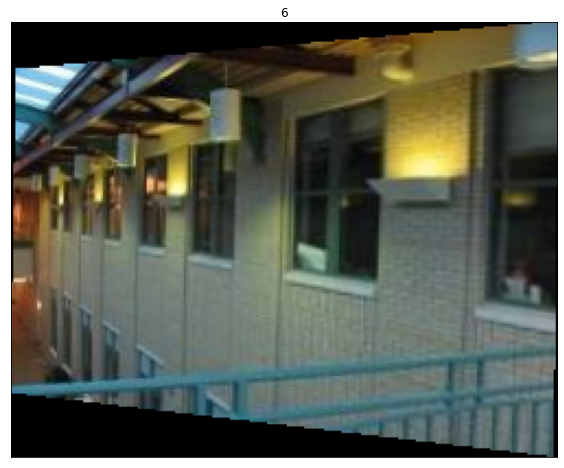

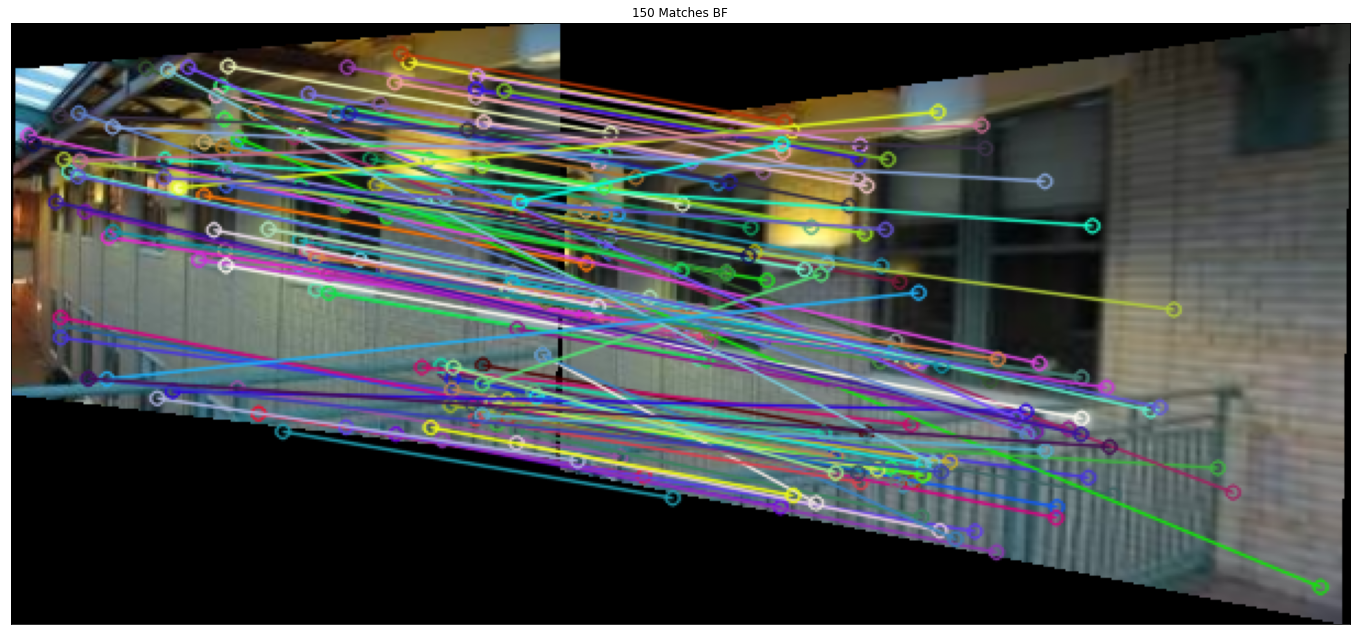

In [ ]:
images = imageList(2)
idxc = 4

# Compute local homographies beetwen images
H = computeLocalHomographies(images)
# Set the canvas
canvas = setCanvas(row=images[idxc].shape[0], col=images[idxc].shape[1], flagColor=3, nim=len(images))
# Compute the homography given axis to the canvas
H0 = axesHomography(len(images), images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H = mosaicHomographies(H, idxc)

height = canvas.shape[0]
width = canvas.shape[1]

img1 = canvas.copy()
img2 = canvas.copy()

k = 0
nH = len(H)-1
for nim in range(len(images)-1, idxc-1, -1):
  if nim == idxc:
    Haux = H0
  else:
    Haux = np.dot(H0, H[nH])
    nH = nH-1
  if (k == 0):
    img2 = cv2.warpPerspective(images[nim], Haux, (width, height), dst=img2, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    displayIm(blackOut(img2), factor=2, title=str(nim))
  elif (k == 1):
    img1 = cv2.warpPerspective(images[nim], Haux, (width, height), dst=img1, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    displayIm(blackOut(img1), factor=2, title=str(nim))
  k += 1

img1 = blackOut(img1)
img2 = blackOut(img2)

# Ya tenemos las imágenes, calculamos los matches

kp1, ds1 = siftPoints(img1)
kp2, ds2 = siftPoints(img2)

matches = matching(ds1, ds2)
showMatches(img1, kp1, img2, kp2, matches, 150, title='150 Matches BF')

Podemos ver como hay bastantes líneas que fallan, llevando algunos puntos a otros distintos, y es debido a esto a que el mosaico no es correcto.

Vamos a intentar solucionarlo aumentando el número de iteraciones de Ransac.

In [ ]:
def homographyExtra(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20):
  # the order is important
  if len(matches) > MIN_MATCH_COUNT:
    # Let's extract  two lists of points in correspondences from matches
    src_pts = []
    dst_pts = []
    for m in matches:
      src_pts.append(kp1[m.queryIdx].pt) 
      dst_pts.append(kp2[m.trainIdx].pt)
    src_pts = np.array(src_pts)
    dst_pts = np.array(dst_pts)
    # before changing parameter values, try first the opencv by default.
    H, mask = cv2.findHomography(src_pts, dst_pts, Ransac_Error, ransacReprojThreshold=20, maxIters=5000)
    # print('Inliers:', sum(mask))
  else:
     print('Error - very few matches')
  return H

def computeLocalHomographiesExtra(images):
  H = []
  Ransac_Error = cv2.RANSAC
  for item in range(0, len(images)-1):
    kp1, ds1 = siftPoints(images[item])
    kp2, ds2 = siftPoints(images[item+1])
    matches = matching(ds1, ds2)
    Haux = homographyExtra(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20)
    H.append(Haux)
    # print(Haux)
  return H

def mosaicoExtra(images, idxc, factor=3):
  # Compute local homographies beetwen images
  H = computeLocalHomographiesExtra(images)
  # Set the canvas
  canvas = setCanvas(row=images[idxc].shape[0], col=images[idxc].shape[1], flagColor=3, nim=len(images))
  # Compute the homography given axis to the canvas
  H0 = axesHomography(len(images), images[idxc].shape, canvas.shape)
  # Compute the homographies between images and the canvas
  H = mosaicHomographies(H, idxc)
  # Compose the mosaic transporting the images into the canvas
  mosaic = composeMosaic(images, canvas, H, idxc, H0, 0)
  displayIm(blackOut(mosaic), factor=factor, title='Mosaico')

images = imageList(2)
mosaicoExtra(images, 4)

Output hidden; open in https://colab.research.google.com to view.

Finalmente, vamos a intentar combinar ambos resultados, usando Ransac como en el resto de los mosaicos para todas las homografías menos la última, que la haremos como acabamos de ver.

In [ ]:
def computeLocalHomographiesExtra2(images):
  H = []
  Ransac_Error = cv2.RANSAC
  for item in range(0, len(images)-1):
    kp1, ds1 = siftPoints(images[item])
    kp2, ds2 = siftPoints(images[item+1])
    matches = matching(ds1, ds2)
    if item == len(images)-2:
      Haux = homographyExtra(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20)
    else:
      Haux = homography(kp1, kp2, matches, Ransac_Error, MIN_MATCH_COUNT=20)
    H.append(Haux)
    # print(Haux)
  return H

def mosaicoExtra2(images, idxc, factor=3):
  # Compute local homographies beetwen images
  H = computeLocalHomographiesExtra2(images)
  # Set the canvas
  canvas = setCanvas(row=images[idxc].shape[0], col=images[idxc].shape[1], flagColor=3, nim=len(images))
  # Compute the homography given axis to the canvas
  H0 = axesHomography(len(images), images[idxc].shape, canvas.shape)
  # Compute the homographies between images and the canvas
  H = mosaicHomographies(H, idxc)
  # Compose the mosaic transporting the images into the canvas
  mosaic = composeMosaic(images, canvas, H, idxc, H0, 0)
  displayIm(blackOut(mosaic), factor=factor, title='Mosaico')

images = imageList(2)
mosaicoExtra2(images, 4)

Output hidden; open in https://colab.research.google.com to view.

Aunque aun así la imagen no es perfecta, ya que seguimos teniendo algunos fallos por la zona de la lámpara en las últimas imágenes, especialmente visible en la valla, hemos conseguido mejorar los resultados.

### Resultados

Vamos a visualizar los resultados obtenidos con todas las demás imágenes. En todos los casos , parece que el resultado obtenido es correcto, ya que, aunque se puede notar las distintas imágenes por los colores, la iluminación y los bordes en negro, el contorno del paisaje coincide, por lo que no voy a entrar en detalles.

En cada caso, la imagen central esta seleccionada a mano realizando varias pruebas.

In [ ]:
images = imageList(1)
mosaico(images, 1)

Output hidden; open in https://colab.research.google.com to view.

Hemos conseguido mejorar los resultados en la parte que fallaba en la lámpara, pero a cambio hemos empeorado los resultados en la valla.

In [ ]:
images = imageList(3)
mosaico(images, 5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(4)
mosaico(images, 5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(5)
mosaico(images, 6, factor=10)

Output hidden; open in https://colab.research.google.com to view.

Debido al elevado número de imágenes usadas para construir esta última imagen, el mosaico resultante queda muy estirado y puede resultar difícil comprovar en los detalles. Para solucionar esto, puede abrirse en una nueva pestaña haciendo click derecho sobre ella y pudiendo así verla pudiéndo hacer zoom.

# **BONUS**: Spherical projection.  (3 points)
Use Examples 4 or 5's images and show the case f=500. You must use all images.

In [ ]:
def spherical_lookupTable(f, imsize):
  # Here we compute the spherical coordinates where the image pixel project.
  # A sphere of radius r=f is fixed.
  # Begin by discretizing the azimuth and elevation ranges according to the image size and the focal length fixed. 
  # Then compute the coordinates on the sphere for each couple of angle-values (azimuth and elevation)
  # return the computed coordinates
  # Slides and Szeliski's book equations will help
  x_centre = imsize[1]/2
  y_centre = imsize[0]/2

  theta = np.arctan2(imsize[1], (2*f))
  phi = np.arctan2(imsize[0], (2*f))

  thetaRange = np.linspace(-theta, theta, imsize[1])
  phiRange = np.linspace(-phi, phi, imsize[0])

  thetaFinal, phiFinal = np.meshgrid(thetaRange, phiRange)
  
  hat_x = np.sin(thetaFinal) * np.cos(phiFinal)
  hat_y = np.sin(phiFinal)
  hat_z = np.cos(thetaFinal) * np.cos(phiFinal)
      
  x = f * hat_x / hat_z + x_centre
  y = f * hat_y / hat_z + y_centre
  return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

def sphericalTrim(images, cutPix):
  # here we eliminate by left and right, above and below each image the number the
  # lines indicates in cutPix=[#row,#column]
  for i in range(len(images)):
    images[i] = images[i][cutPix[0]:-cutPix[0]:, cutPix[1]:-cutPix[1]:, :]
  return images

def sphericalProjection(images, f, cutpix):
  # Here we interpolate a rectangular mesh of values from the  projection of the pixels.
  # images: set of images; f: focal length; cutpix: #row and #column to remove
  shpim = []
  for image in images:
    x, y = spherical_lookupTable(f, image.shape)
    out = np.zeros(image.size, dtype=np.uint8)
    out = cv2.remap(src=image, map1=x, map2=y, interpolation=cv2.INTER_CUBIC)#, borderMode=cv2.BORDER_TRANSPARENT)
    shpim.append(out)

  # after projection images must be trimmed
  shpim = sphericalTrim(shpim, cutpix)
  return shpim  # vector of projected images

Para obtener los ángulos usamos:
$$\tan\theta = \frac{\frac{imWidth}{2}}{f}$$
y
$$\tan\phi = \frac{\frac{imHeight}{2}}{f}$$
Y con esto, los puntos sobre la esfera son los siguientes:
$$(sin\theta\cos\phi, \sin\phi, \cos\theta\cos\phi) = (\hat{x}, \hat{y}, \hat{z})$$
Finalmente, para obtener el mapeado utilizamos:
$$x = f\frac{\hat{x}}{\hat{z}} + x_{center}$$
$$y = f\frac{\hat{y}}{\hat{z}} + y_{center}$$
Y utilizamos la función cv2.remap para pasar los puntos de la imágen original a este mapeado.

Finalmente, recortamos los bordes de las imágenes con sphericalTrim para eliminar pixeles que quedaran en negro.

Con todas las funciones definidas, vamos a realizar una prueba viendo como 𝑓 (focal length) afecta a los resultados.

In [ ]:
images = imageList(1)
focals = [50, 100, 200, 500, 1000]
images1 = [images[0]]
images2 = [images[1]]
images3 = [images[2]]
images4 = [images[3]]
for f in focals:
  imgs = sphericalProjection(images, f=f, cutpix=[10,10])          
  images1.append(imgs[0])
  images2.append(imgs[1])
  images3.append(imgs[2])
  images4.append(imgs[3])

for i in range(len(focals)):
  focals[i] = str(focals[i])
focals.insert(0, "0")

print_images_titles(images1, titles=focals, factor=4, rows=1)
print_images_titles(images2, titles=focals, factor=4, rows=1)
print_images_titles(images3, titles=focals, factor=4, rows=1)
print_images_titles(images4, titles=focals, factor=4, rows=1)

Output hidden; open in https://colab.research.google.com to view.

Podemos ver en las imágenes anteriores, la imágemes del primer mosaico con las transformaciones necesarias para la proyección esférica con distintos valores de f.

Nótese que f=0 no es el resultado de aplicar la transformación con f=0, sino la imagen original para poder comparar.

Podemos ver como, con valores pequelos de f, la imagen queda mucho mas deformada, especialmente por los bordes, mientras que al aumentarlo, se parece más a la original.

Finalmente, definimos la nueva función que construirá los mosaicos, que funciona igual que la función del ejercicio 3, con la diferencia que primero aplicamos las transformaciones necesarias para la proyección esférica, y construimos el mosaico con estas imágenes obtenidas.

In [ ]:
from numpy.linalg import inv

def SphericalMosaico(images, idxc, cut=20, factor=3, f=500):
  images = sphericalProjection(images, f=f, cutpix=[cut,cut])
  print_images_titles(images, factor=2, rows=1)
  # Compute local homographies beetwen images
  H = computeLocalHomographies(images)
  # Set the canvas
  canvas = setCanvas(row=images[idxc].shape[0], col=images[idxc].shape[1], flagColor=3, nim=len(images))
  # Compute the homography given axis to the canvas
  H0 = axesHomography(len(images), images[idxc].shape, canvas.shape)
  # Compute the homographies between images and the canvas
  H = mosaicHomographies(H, idxc)
  # Compose the mosaic transporting the images into the canvas
  mosaic = composeMosaic(images, canvas, H, idxc, H0, 0)
  displayIm(blackOut(mosaic), factor=factor, title='Mosaico')

### Resultados

Vamos a ver los resultados obtenidos en todos los mosaicos con la proyección esférica. En todos los casos, menos en el último de la Sierra, los resultados parecen correctos, por lo que no voy a entrar en detalle.

In [ ]:
Çimages = imageList(1)
SphericalMosaico(images, 1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(2)
SphericalMosaico(images, 4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(3)
SphericalMosaico(images, 5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(4)
SphericalMosaico(images, 5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = imageList(5)
SphericalMosaico(images, 6, cut=20, factor=3)

Output hidden; open in https://colab.research.google.com to view.

En este caso, las imágenes de los bordes quedan demasiado deformadas, siendo casi imposible apreciar nada. Para solucionarlo, aumentamos el valor de f, para que así las deformaciones no sean tan grandes.

In [ ]:
images = imageList(5)
SphericalMosaico(images, 6, cut=20, factor=3, f=1000)

Output hidden; open in https://colab.research.google.com to view.